In [1]:
%load_ext autoreload
%autoreload 2

(<Figure size 1200x1200 with 16 Axes>,
 array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
         <Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>],
        [<Axes: title={'center': '4'}>, <Axes: title={'center': '5'}>,
         <Axes: title={'center': '6'}>, <Axes: title={'center': '7'}>],
        [<Axes: title={'center': '8'}>, <Axes: title={'center': '9'}>,
         <Axes: title={'center': '10'}>, <Axes: title={'center': '11'}>],
        [<Axes: title={'center': '12'}>, <Axes: title={'center': '13'}>,
         <Axes: title={'center': '14'}>, <Axes: title={'center': '15'}>]],
       dtype=object))

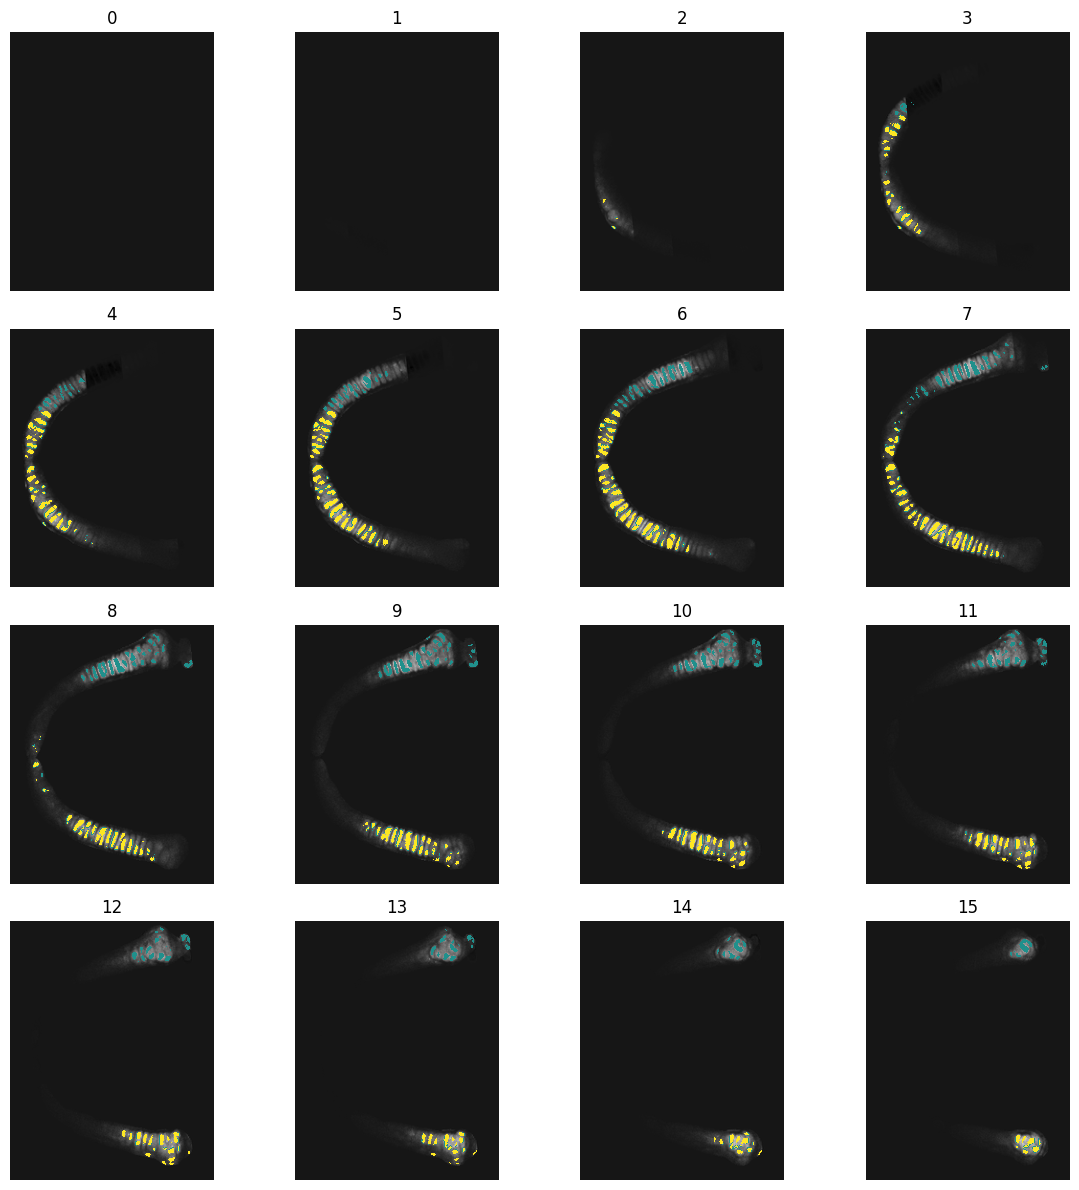

In [2]:
"""
Display two images I'm using for training

"""

import os
import numpy as np
from dev import plot, util

folder = os.path.join(util.userconf()["rdsf_dir"], "Yushi/Videos/theta_1/Code/segmenter/notebooks/projects/20180701_cell_segment/")
img_path = folder + "jaw_raw_image.npy"
mask_path = folder + "jaw_labels.npy"

img = np.load(img_path)
mask = np.load(mask_path)

# Convert the mask to labels
mask[(mask < 32) & (mask > 0)] = 1
mask[mask >= 32] = 2

img = np.transpose(img, (2, 0, 1))
mask = np.transpose(mask, (2, 0, 1))

plot.plot_arr(img, mask)

In [3]:
"""
Ignore all that and use a brain MRI dataset

"""

import torch.utils
import torchio as tio
from dev import image_io

transform = image_io.random_transforms()

subjectdataset = tio.datasets.ixi.IXITiny(
    root="tmp_data/", transform=transform, download=True
)

# This is slow and bad
indices = np.arange(len(subjectdataset))
np.random.shuffle(indices)
train_idx, val_idx, test_idx = np.split(
    indices, [int(0.8 * len(indices)), len(indices) - 1]
)
print(len(train_idx), len(val_idx), len(test_idx))

train_data = tio.SubjectsDataset([subjectdataset[i] for i in train_idx])
val_data = tio.SubjectsDataset([subjectdataset[i] for i in test_idx])
test_data = tio.SubjectsDataset([subjectdataset[i] for i in train_idx])

del subjectdataset

len(train_data), len(val_data), len(test_data)

Root directory for IXITiny found: tmp_data
452 113 1


(452, 1, 452)

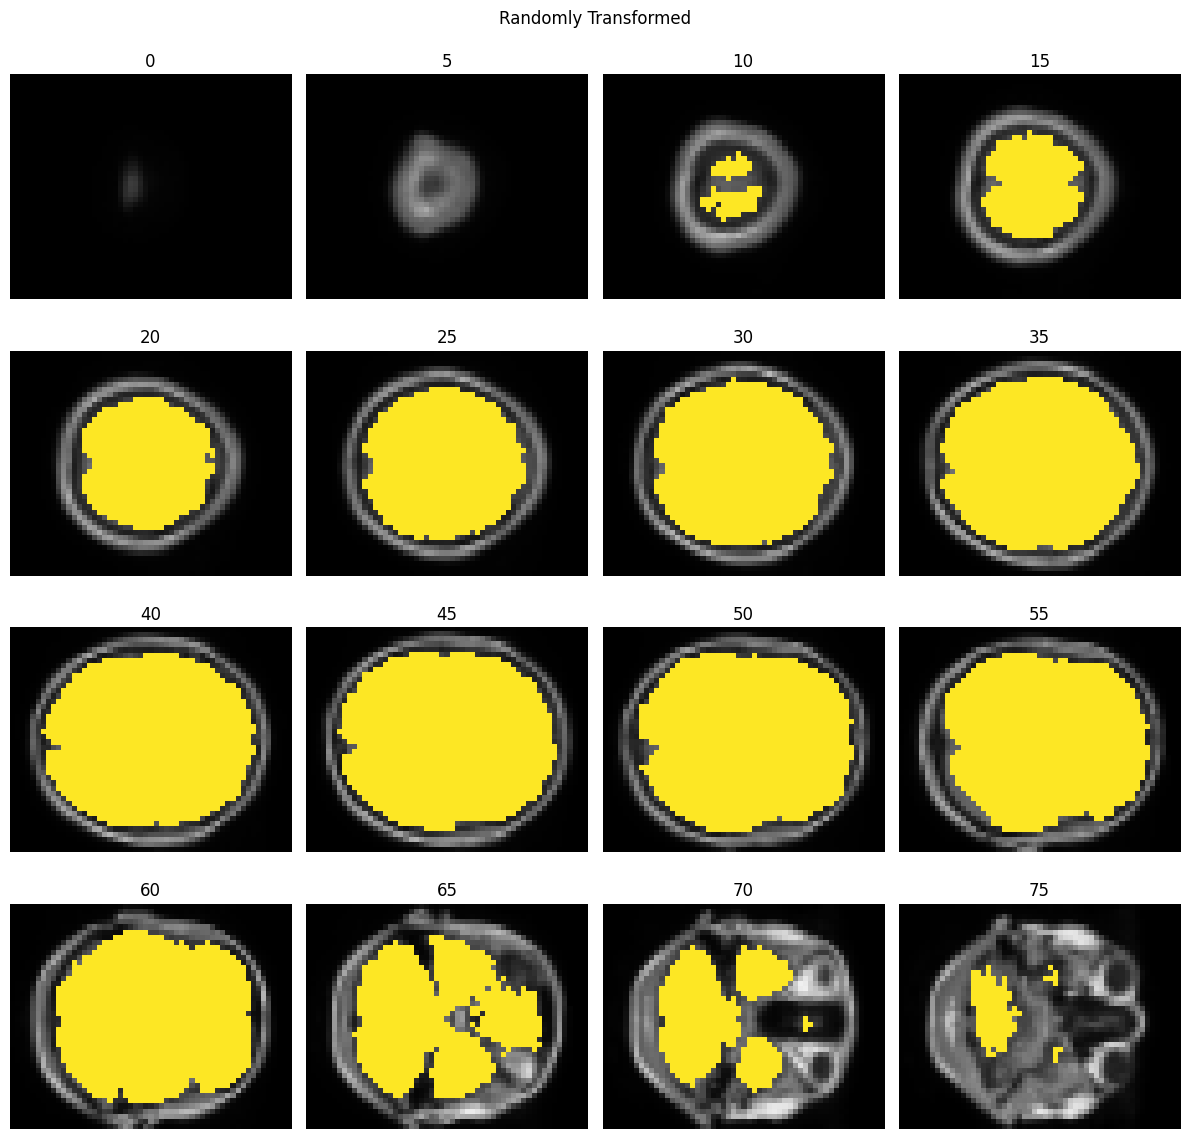

In [4]:
fig, _ = plot.plot_arr(
    image_io.pytorch2img(train_data[0].image.data.squeeze()),
    image_io.pytorch2img(train_data[0].label.data.squeeze()),
)
fig.suptitle("Randomly Transformed")
fig.tight_layout()


In [5]:
""" Create a DataLoader"""

import torch
from dev.util import userconf

uconf = userconf()
patch_size = [int(x) for x in uconf["patch_size"].split(",")]
print(f"Patch size: {patch_size}")


def dataloader(dataset: tio.SubjectsDataset):
    # Choose the probability of patches being centred on each value
    label_probs = {0: 1, 1: 1, 2: 1}
    patch_sampler = tio.LabelSampler(
        patch_size=patch_size, label_probabilities=label_probs
    )
    patches = tio.Queue(
        dataset,
        max_length=10000,
        samples_per_volume=6,
        sampler=patch_sampler,
        num_workers=10,
    )

    return torch.utils.data.DataLoader(
        patches,
        batch_size=uconf["batch_size"],
        shuffle=False,
        num_workers=0,
        pin_memory=torch.cuda.is_available(),
    )

train_loader = dataloader(train_data)
val_loader = dataloader(val_data)
test_loader = dataloader(test_data)

Patch size: [32, 32, 32]


In [6]:
"""
Load a model

"""

from dev.segmentation import model as lib_model

model = lib_model.model()
# lib_model.draw_model(model, "model.pdf")

In [7]:
"""
Create an optimiser + choose a loss function

"""

from monai.losses import TverskyLoss

optimiser = lib_model.optimiser(model)
loss = TverskyLoss(include_background=True, to_onehot_y=True, alpha=0.2)

optimiser

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0026
    maximize: False
    weight_decay: 0
)

In [8]:
import warnings
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    # Yellow text
    yellow = "\033[33m"
    clear = "\033[0m"
    warnings.warn(f"{yellow}This might not be what you want!{clear}")
print(f"Using {device} device")

_ = model.to(device)

Using cuda device


In [9]:
model, train_loss, val_loss = lib_model.train(
    model,
    optimiser,
    loss,
    train_loader,
    val_loader,
    device=device,
    epochs=25,
)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [01:56<00:00, 38.81s/it]


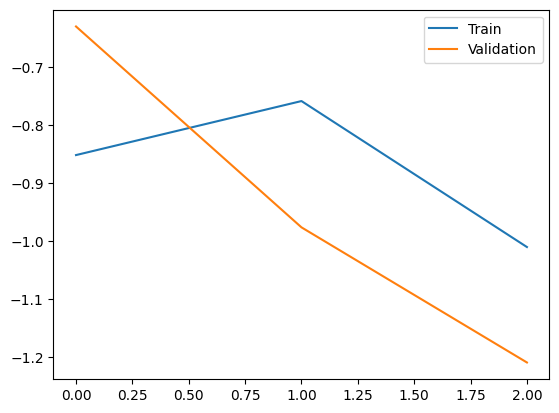

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label="Train")
plt.plot(val_loss, label="Validation")
plt.legend()

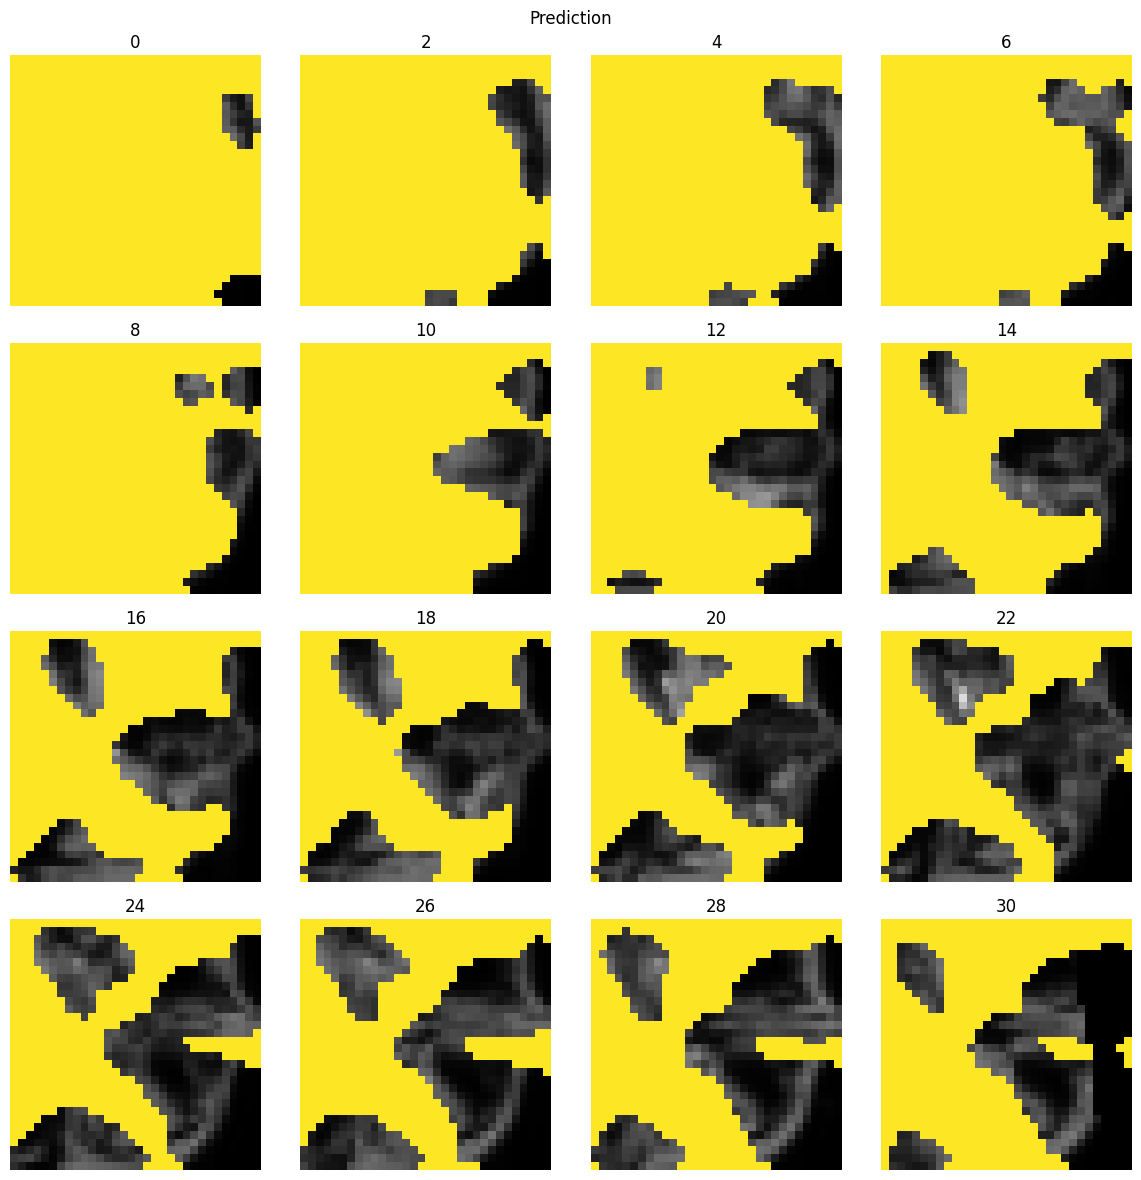

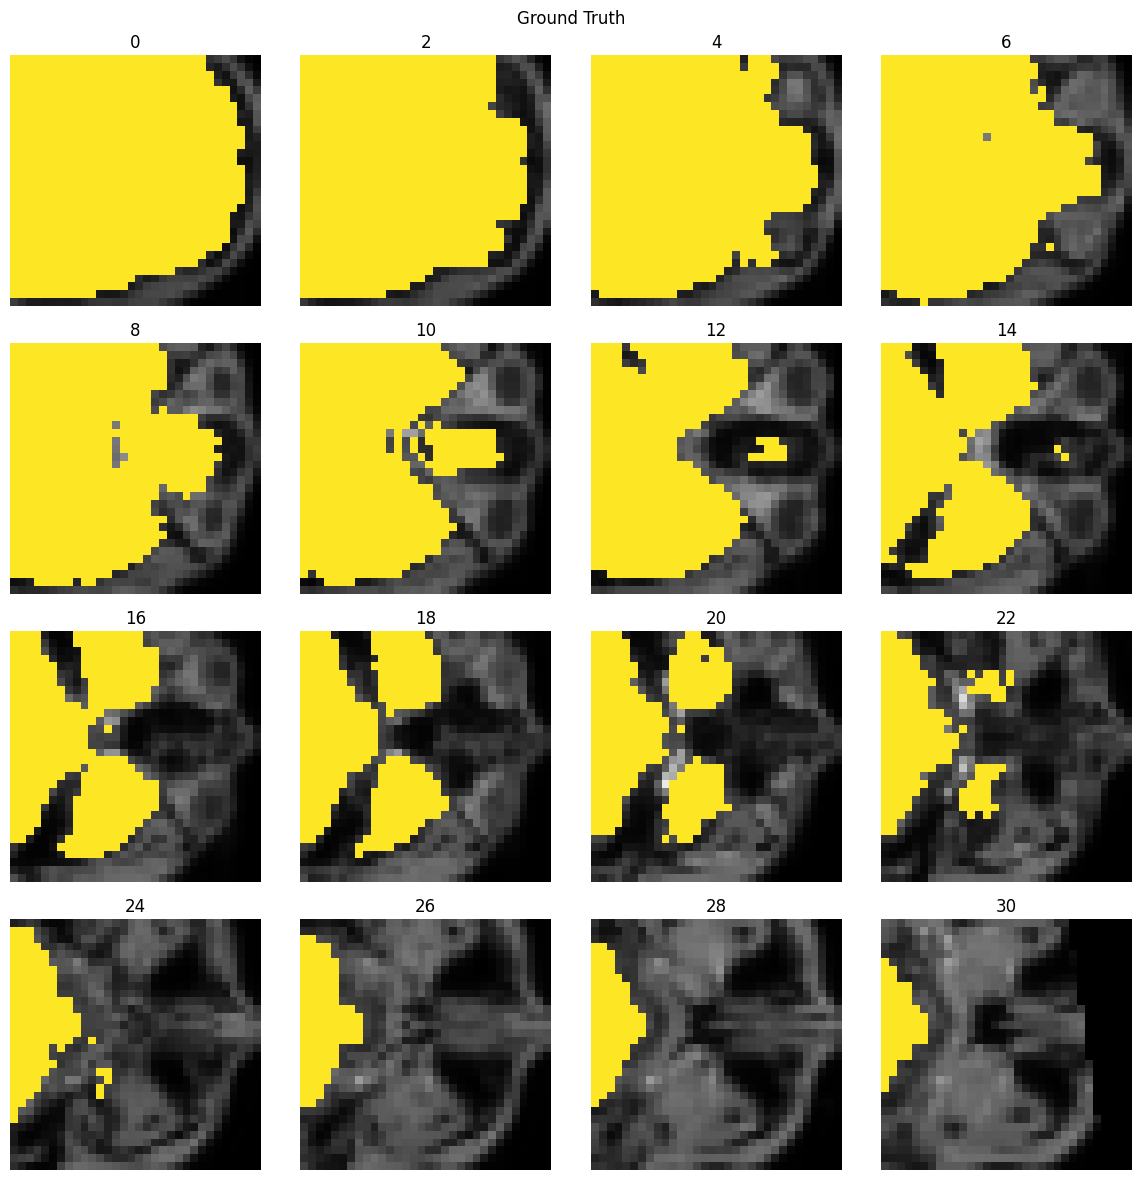

In [11]:
"""
Show the result on the test data

"""
test_patch = next(iter(test_loader)) if not "test_patch" in locals() else test_patch

test_data = test_patch["image"]["data"]
test_label = test_patch["label"]["data"]

prediction = model(test_data.to(device)).to("cpu").detach()

# Convert one-hot to labels
prediction = prediction.argmax(dim=1)

# Convert to numpy
test_data = test_data.squeeze(1).numpy()
test_label = test_label.squeeze(1).numpy()

# Extract just one patch
i = 0
prediction = prediction[i]
test_data = test_data[i]
test_label = test_label[i]

fig, _ = plot.plot_arr(test_data, prediction)
fig.suptitle("Prediction")
fig.tight_layout()

fig, _ = plot.plot_arr(test_data, test_label)
fig.suptitle("Ground Truth")
fig.tight_layout()